### Example notebook to load QSS divertor spectroscopy data and process is

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import copy
import json
import codecs
import logging
logging.basicConfig(level=logging.CRITICAL, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger("divertor_spectroscopy")
logger.setLevel(logging.DEBUG)

from divertor_spectroscopy import utilities as utils
from divertor_spectroscopy import datasource_qss
from divertor_spectroscopy import spectrum
from divertor_spectroscopy import wavelength_calibration
#from divertor_spectroscopy import QSS_search
from divertor_spectroscopy import analysis
from divertor_spectroscopy import instrument


colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### The following cell is for input

In [8]:
# spectrometer and discharge
pid = "20230223.072" # ICRH example
pid = "20230118.030"
camid = "IP160_4" # this is standard from AEF51 and 405 nm
debug = True
# The following things are usually read automatically, but here you need to put them in
experiment_length = 4 # this is very pedestiran, but quickly I can't use my way here
config = "EJM"


# datasource
wcal = False # will use the already existing calibration
wcal_comment = None # will find correct wl calibration automatically
ical = True
ical_comment = None # will load ical automatically
instrument_cal = True # loads width per channel for gaussian fits
numeric_instrument_function = True # loads numeric instrument function per channel
instrument_function_mode = "gauss"
#instrument_function_mode = "convolution_entire_spectrum"
central_wavelength = None # rarely the automatic saving of this parameter failed, then you need to go manually
database_path = None # handled automatically
broken_channels = None # handled automatically

# wavelength calibration
zeeman=False # use zeeman effect - will slow the code down
special_tags_model = False # this is relevant if you want to debug pec_lines
exclude_saturation_in_wl_calibration = True
save_wavelength_calibration = True
fit_coefficients=False # fits your first and second wl calibration as these should not change over the chip

# here you 
analysis_start = 0
analysis_end = experiment_length
analysis_step = 0.5 # 

save_fits = False
fontsize =14
show_positions = False
scale = "log"
xlim = None


### This cell will produce secondary data to this input

In [9]:
ground_path = ""
save_path = ground_path+pid+"/"
# datasource
if ical:
    signal_type = "signal_photons"
    intensity_label=r"Intensity [Photons/($\mathrm{m}^2$ nm sr s)]"
else:
    signal_type = "signal_counts"
    intensity_label = "Intensity [Counts]"

if camid == "IP320_2" or camid == "IP320_1":
    port = "AEF51"
if camid == "IP320_3" or camid == "IP320_4" or camid == "IP160_4":
    port = "AEI51"
if config[0] == "E":
    strikelines = ["horizontal","vertical"]
if config[0] == "K":
    strikelines = ["vertical"]
if config[0] == "D":
    strikelines = ["horizontal"]
exclude_channels = {}
exclude_channels["horizontal"] = np.arange(16,27)
exclude_channels["vertical"] = np.arange(0,16)
ls = {"horizontal":"-","vertical":"--"}

### QSS datasource:

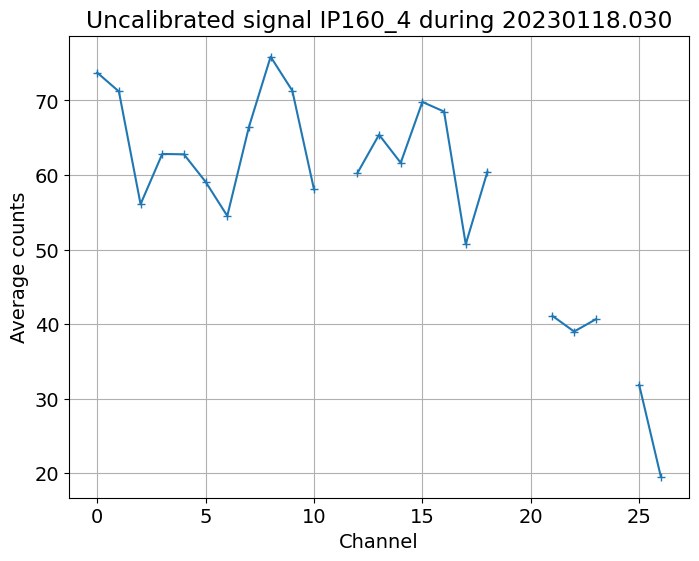

2024-03-01 14:38:08,395 - divertor_spectroscopy.datasource_qss - DEBUG - You need to produce your wavelength vector yourself


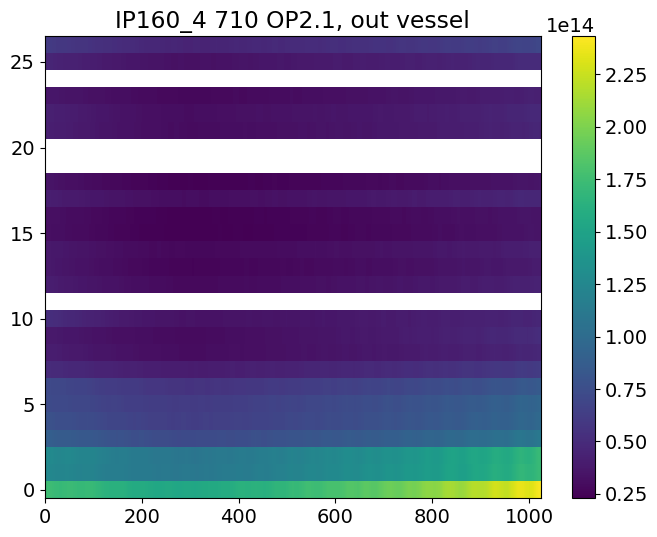

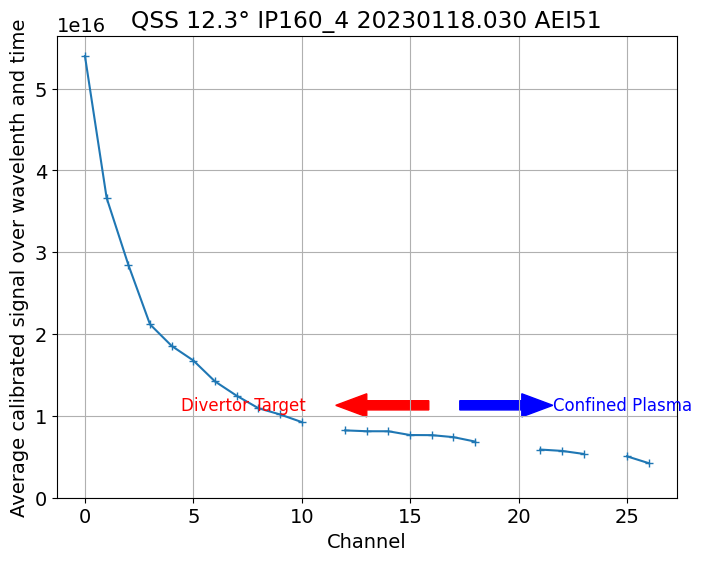

In [10]:
ds_qss = datasource_qss.Datasource_qss(database_path=database_path,time_id=pid,camid=camid,port=port,broken_channels=broken_channels,wcal=wcal,wcal_comment=wcal_comment,ical=ical,ical_comment=ical_comment,instrument_cal=instrument_cal,numeric_instrument_function=numeric_instrument_function,central_wavelength=central_wavelength,debug=debug)
ds_qss.central_wavelength = int(np.round(ds_qss.metadata["centralWavelength"]))
ds_qss.experiment_length = experiment_length

### Load model used for wl calibration using default paramters of model

In [11]:
model = spectrum.load_model(camid=camid,central_wavelength=ds_qss.central_wavelength,zeeman=zeeman)

### Wavelength calibration:

2024-03-01 14:38:12,868 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.858298227722504, 16.102944782285878, 17.006011150077192, 17.07654789019657, 16.268090125083983, 17.752470817459788, 18.00578963096126, 17.486248772148254]
2024-03-01 14:38:12,870 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 15.205784037628046, 15.205784037628046, 15.205784037628046, 15.205784037628046, 15.205784037628046, 15.205784037628046, 15.205784037628046, 15.205784037628046]
2024-03-01 14:38:12,872 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 20.3885977882572, 20.3885977882572, 20.3885977882572, 20.3885977882572, 20.3885977882572, 20.3885977882572, 20.3885977882572, 20.3885977882572]


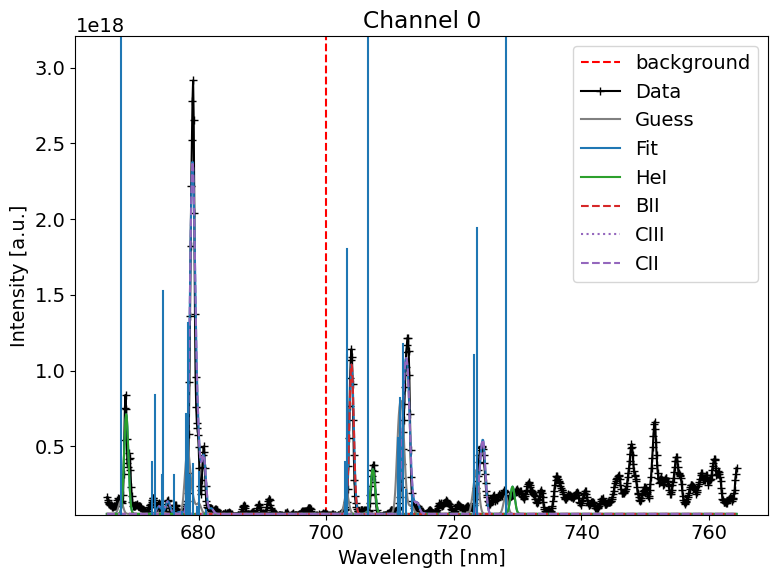

2024-03-01 14:38:13,828 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.709424395504914, 16.11538314502576, 16.701126687018547, 17.35095135273017, 16.359847648918187, 18.005090622233137, 17.981991222851573, 17.36446885729318]
2024-03-01 14:38:13,829 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 15.012604185668032, 15.012604185668032, 15.012604185668032, 15.012604185668032, 15.012604185668032, 15.012604185668032, 15.012604185668032, 15.012604185668032]
2024-03-01 14:38:13,830 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 20.265763009446434, 20.265763009446434, 20.265763009446434, 20.265763009446434, 20.265763009446434, 20.265763009446434, 20.265763009446434, 20.265763009446434]


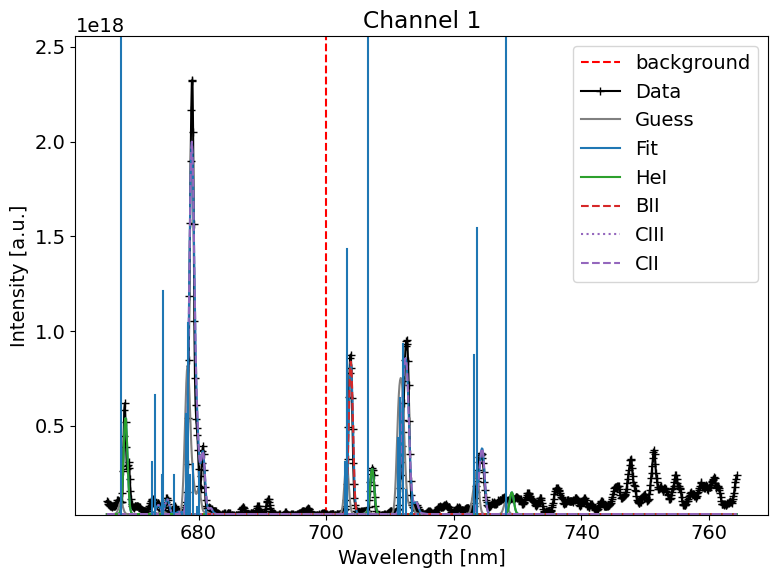

2024-03-01 14:38:14,765 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.698753238385482, 16.385970794279807, 16.547018216040254, 17.5316856694723, 16.49730195183118, 18.131902200929037, 17.94618937446918, 17.27030821312512]
2024-03-01 14:38:14,766 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.879282572143847, 14.879282572143847, 14.879282572143847, 14.879282572143847, 14.879282572143847, 14.879282572143847, 14.879282572143847, 14.879282572143847]
2024-03-01 14:38:14,767 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 20.177719435048637, 20.177719435048637, 20.177719435048637, 20.177719435048637, 20.177719435048637, 20.177719435048637, 20.177719435048637, 20.177719435048637]


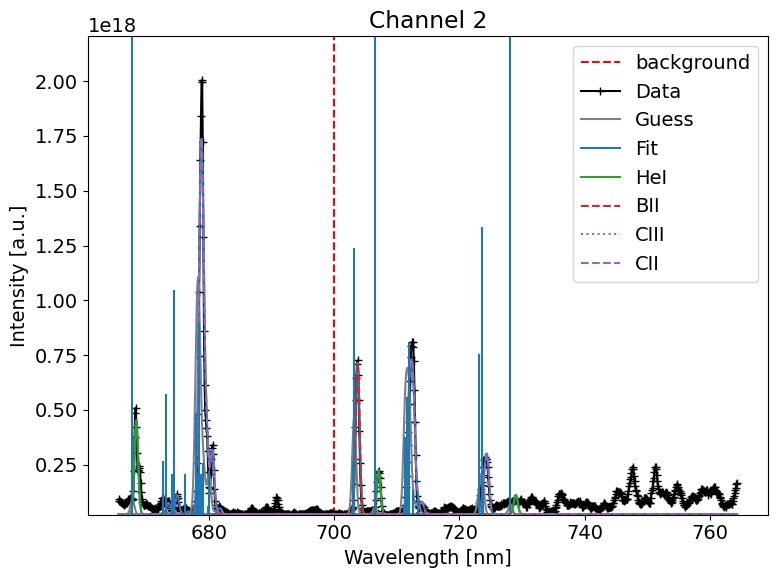

2024-03-01 14:38:15,951 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.57609677971861, 16.55811619296852, 16.384571012006894, 17.59577939352267, 16.612470473078144, 18.17027552844376, 17.893176246360113, 17.188295132664607]
2024-03-01 14:38:15,953 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.726257230710463, 14.726257230710463, 14.726257230710463, 14.726257230710463, 14.726257230710463, 14.726257230710463, 14.726257230710463, 14.726257230710463]
2024-03-01 14:38:15,954 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 20.075439644611873, 20.075439644611873, 20.075439644611873, 20.075439644611873, 20.075439644611873, 20.075439644611873, 20.075439644611873, 20.075439644611873]


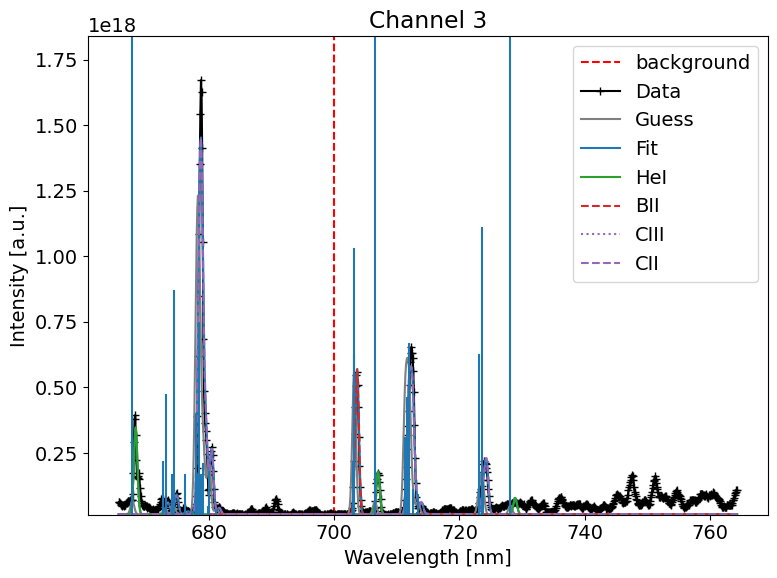

2024-03-01 14:38:17,106 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.652630108039293, 16.749416122567332, 16.366797104590724, 17.65254106422291, 16.787533227358566, 18.220787957995405, 17.91264552058285, 17.194976233961217]
2024-03-01 14:38:17,109 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.644965162542839, 14.644965162542839, 14.644965162542839, 14.644965162542839, 14.644965162542839, 14.644965162542839, 14.644965162542839, 14.644965162542839]
2024-03-01 14:38:17,110 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 20.027422614512208, 20.027422614512208, 20.027422614512208, 20.027422614512208, 20.027422614512208, 20.027422614512208, 20.027422614512208, 20.027422614512208]


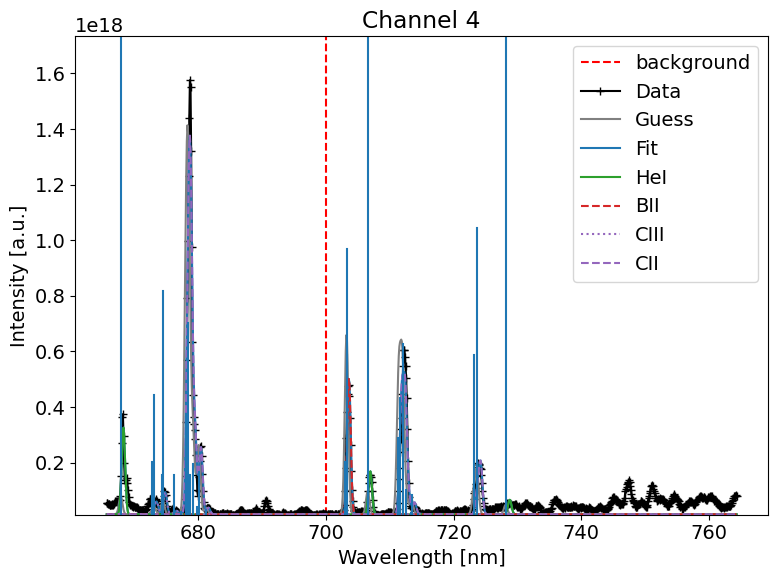

2024-03-01 14:38:18,135 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.84817943673826, 16.83932773915882, 16.355427464499552, 17.67151323916096, 16.971534457153385, 18.235421994755182, 17.94027336088251, 17.217386718375817]
2024-03-01 14:38:18,137 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.578636011310415, 14.578636011310415, 14.578636011310415, 14.578636011310415, 14.578636011310415, 14.578636011310415, 14.578636011310415, 14.578636011310415]
2024-03-01 14:38:18,138 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.981501438964123, 19.981501438964123, 19.981501438964123, 19.981501438964123, 19.981501438964123, 19.981501438964123, 19.981501438964123, 19.981501438964123]


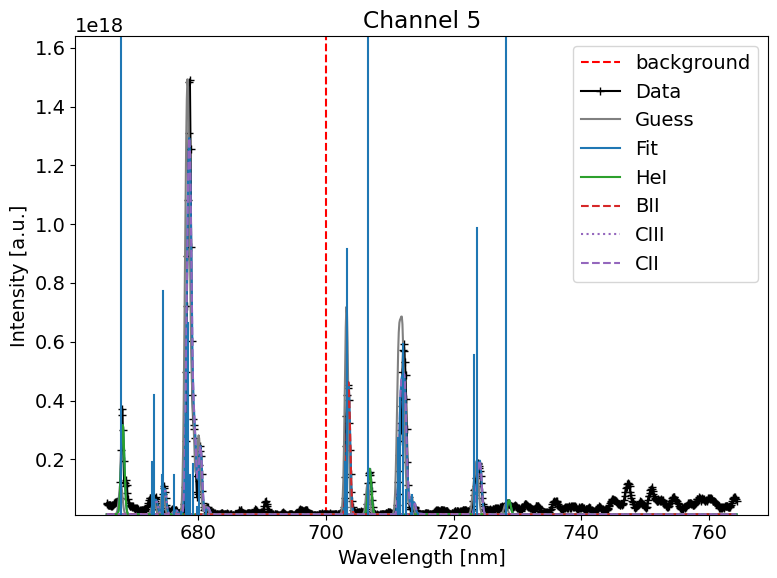

2024-03-01 14:38:19,285 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 17.046100047878156, 16.860457652431876, 16.322650238795568, 17.60281663899669, 17.054992129361416, 18.207144418065226, 17.892485898172605, 17.175105833358845]
2024-03-01 14:38:19,286 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.485244632217285, 14.485244632217285, 14.485244632217285, 14.485244632217285, 14.485244632217285, 14.485244632217285, 14.485244632217285, 14.485244632217285]
2024-03-01 14:38:19,288 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.905912843728835, 19.905912843728835, 19.905912843728835, 19.905912843728835, 19.905912843728835, 19.905912843728835, 19.905912843728835, 19.905912843728835]


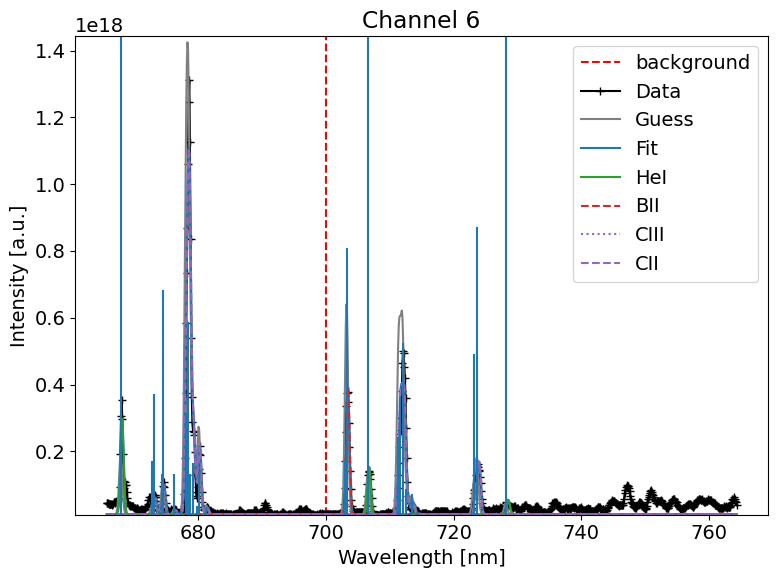

2024-03-01 14:38:20,197 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 17.208679733742827, 16.89899962337814, 16.309314490376785, 17.535047740390077, 17.100802987676712, 18.199551063357184, 17.873096265379086, 17.13161807909749]
2024-03-01 14:38:20,198 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.408878548467914, 14.408878548467914, 14.408878548467914, 14.408878548467914, 14.408878548467914, 14.408878548467914, 14.408878548467914, 14.408878548467914]
2024-03-01 14:38:20,199 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.844323225280775, 19.844323225280775, 19.844323225280775, 19.844323225280775, 19.844323225280775, 19.844323225280775, 19.844323225280775, 19.844323225280775]


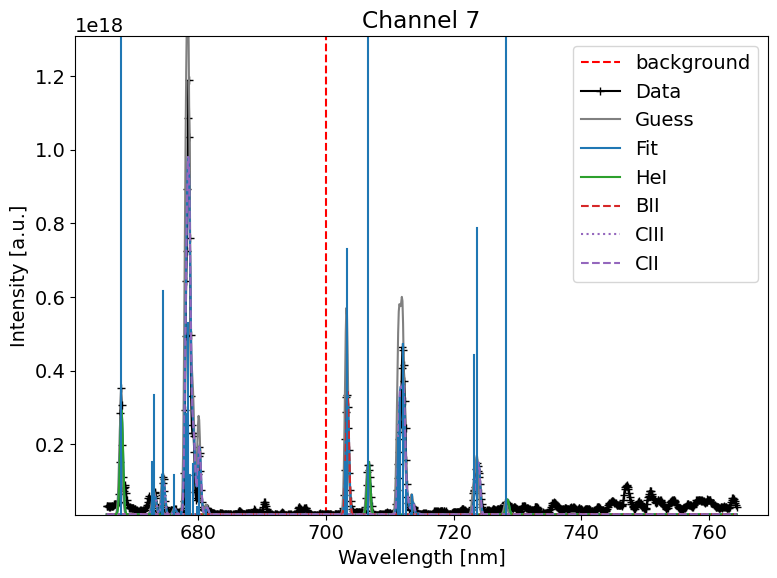

2024-03-01 14:38:21,107 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 17.272576432250442, 16.87356515489801, 16.28912845847008, 17.446091418690685, 17.093705264465513, 18.15969139621828, 17.80245631344258, 17.052060549106486]
2024-03-01 14:38:21,109 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.335960057962428, 14.335960057962428, 14.335960057962428, 14.335960057962428, 14.335960057962428, 14.335960057962428, 14.335960057962428, 14.335960057962428]
2024-03-01 14:38:21,111 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.76526091311777, 19.76526091311777, 19.76526091311777, 19.76526091311777, 19.76526091311777, 19.76526091311777, 19.76526091311777, 19.76526091311777]


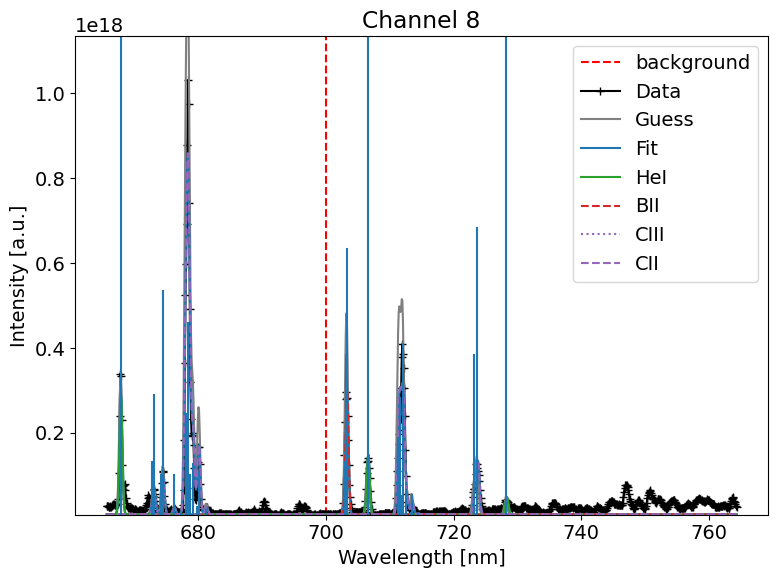

2024-03-01 14:38:21,959 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 17.29654897736819, 16.86960401626519, 16.280413647834063, 17.354259919988127, 17.003466692452402, 18.08933463178949, 17.74406232675194, 16.97936960498402]
2024-03-01 14:38:21,961 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.28751601415803, 14.28751601415803, 14.28751601415803, 14.28751601415803, 14.28751601415803, 14.28751601415803, 14.28751601415803, 14.28751601415803]
2024-03-01 14:38:21,962 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.695295568691478, 19.695295568691478, 19.695295568691478, 19.695295568691478, 19.695295568691478, 19.695295568691478, 19.695295568691478, 19.695295568691478]


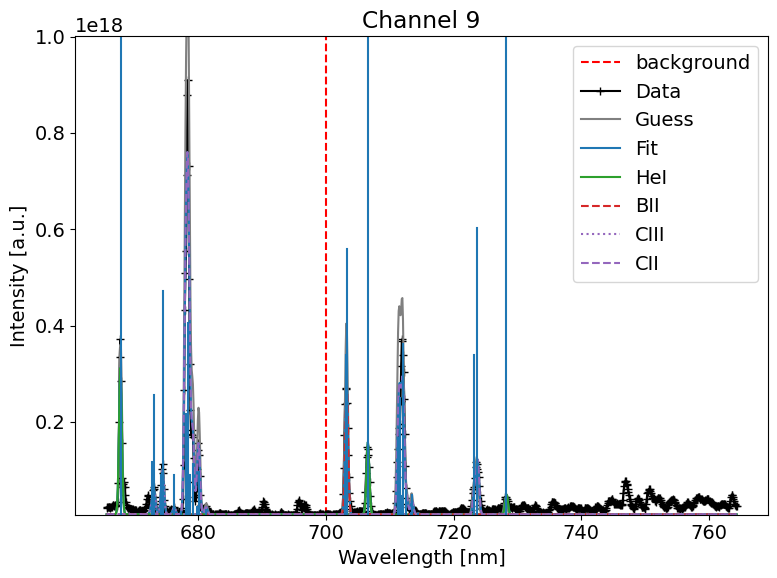

2024-03-01 14:38:22,761 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 17.23899388510547, 16.814510192814595, 16.238870520845254, 17.20508021353815, 16.868645102188978, 17.981377287377764, 17.660280305398484, 16.894622735602987]
2024-03-01 14:38:22,762 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.232000576982188, 14.232000576982188, 14.232000576982188, 14.232000576982188, 14.232000576982188, 14.232000576982188, 14.232000576982188, 14.232000576982188]
2024-03-01 14:38:22,764 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.61986643485582, 19.61986643485582, 19.61986643485582, 19.61986643485582, 19.61986643485582, 19.61986643485582, 19.61986643485582, 19.61986643485582]


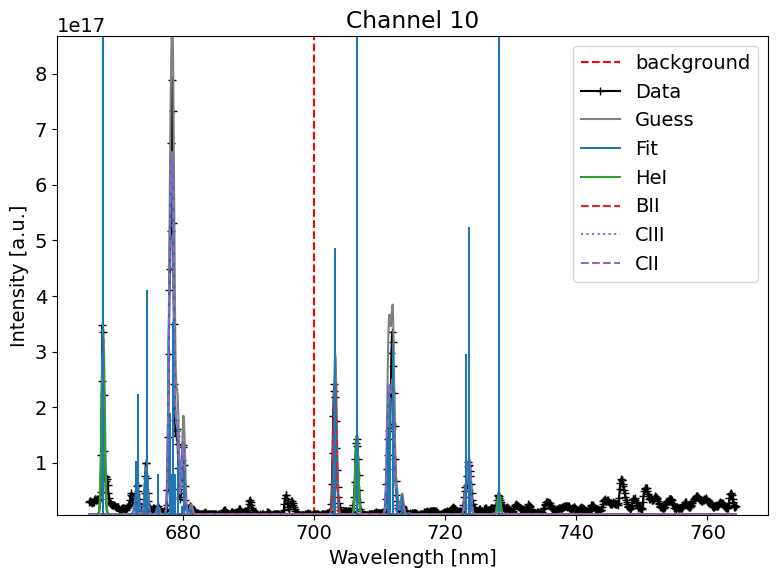

2024-03-01 14:38:23,562 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 17.01186971432475, 16.684975247285443, 16.17343468049797, 16.94502281071875, 16.59979071861775, 17.76538279627455, 17.53350359259628, 16.780455020143584]
2024-03-01 14:38:23,563 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.15987408315275, 14.15987408315275, 14.15987408315275, 14.15987408315275, 14.15987408315275, 14.15987408315275, 14.15987408315275, 14.15987408315275]
2024-03-01 14:38:23,564 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.550484807399275, 19.550484807399275, 19.550484807399275, 19.550484807399275, 19.550484807399275, 19.550484807399275, 19.550484807399275, 19.550484807399275]


Skipping broken channel 11


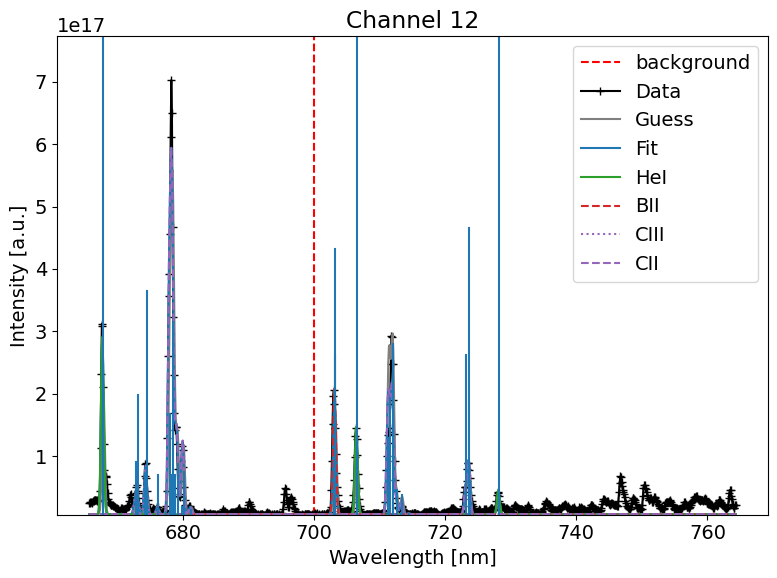

2024-03-01 14:38:24,303 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.8961450972312, 16.60722563161463, 16.12192069454984, 16.835944197947804, 16.511351009998133, 17.671843551590477, 17.491079657978716, 16.743855549538452]
2024-03-01 14:38:24,305 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.148285339043987, 14.148285339043987, 14.148285339043987, 14.148285339043987, 14.148285339043987, 14.148285339043987, 14.148285339043987, 14.148285339043987]
2024-03-01 14:38:24,306 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.53544869890509, 19.53544869890509, 19.53544869890509, 19.53544869890509, 19.53544869890509, 19.53544869890509, 19.53544869890509, 19.53544869890509]


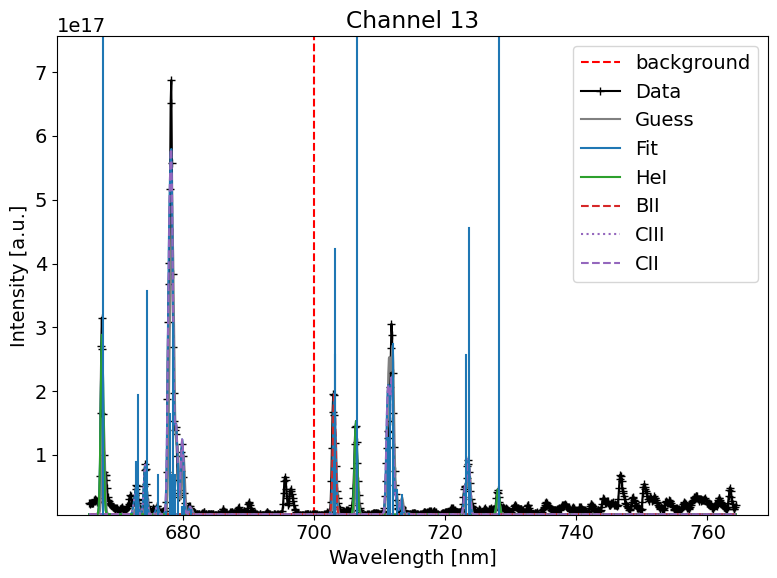

2024-03-01 14:38:25,058 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.841060860875153, 16.515362241427887, 16.04559572663886, 16.739812787121853, 16.450974415518886, 17.600804923542746, 17.40638606948716, 16.671164468944543]
2024-03-01 14:38:25,061 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.144051259960804, 14.144051259960804, 14.144051259960804, 14.144051259960804, 14.144051259960804, 14.144051259960804, 14.144051259960804, 14.144051259960804]
2024-03-01 14:38:25,062 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.505210422458003, 19.505210422458003, 19.505210422458003, 19.505210422458003, 19.505210422458003, 19.505210422458003, 19.505210422458003, 19.505210422458003]


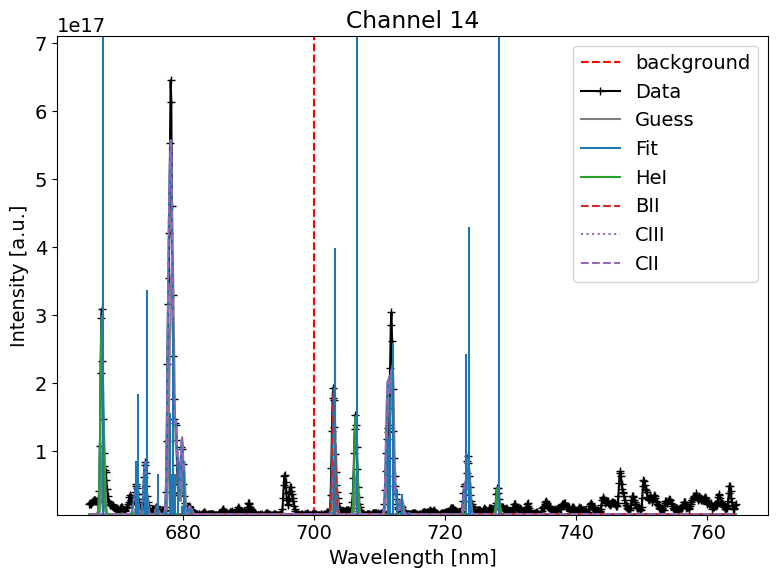

2024-03-01 14:38:25,812 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.787837026988893, 16.437378454609597, 15.992786826745277, 16.64737806398883, 16.40786031875579, 17.526666482431665, 17.321788300452074, 16.578214319039418]
2024-03-01 14:38:25,813 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.118337385882164, 14.118337385882164, 14.118337385882164, 14.118337385882164, 14.118337385882164, 14.118337385882164, 14.118337385882164, 14.118337385882164]
2024-03-01 14:38:25,815 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.46334243995846, 19.46334243995846, 19.46334243995846, 19.46334243995846, 19.46334243995846, 19.46334243995846, 19.46334243995846, 19.46334243995846]


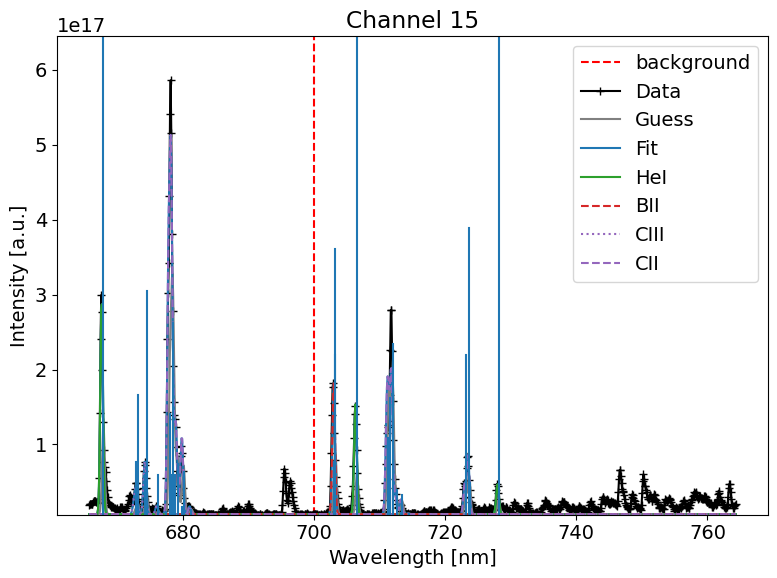

2024-03-01 14:38:26,463 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.78206222270108, 16.38848007678645, 15.970768927178774, 16.619177707686898, 16.3803744093102, 17.480432084862287, 17.241590275321833, 16.534073834215526]
2024-03-01 14:38:26,464 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.120036726697098, 14.120036726697098, 14.120036726697098, 14.120036726697098, 14.120036726697098, 14.120036726697098, 14.120036726697098, 14.120036726697098]
2024-03-01 14:38:26,466 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.415384121413663, 19.415384121413663, 19.415384121413663, 19.415384121413663, 19.415384121413663, 19.415384121413663, 19.415384121413663, 19.415384121413663]


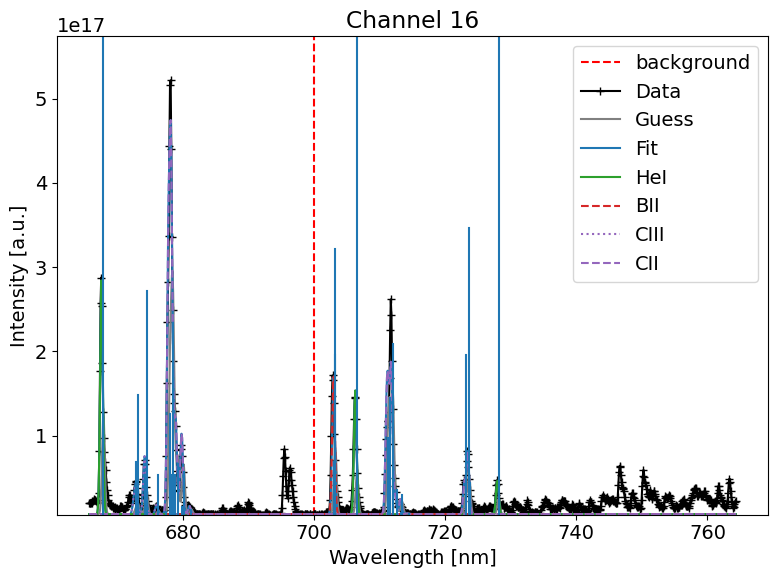

2024-03-01 14:38:27,191 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.81615940768934, 16.367676901575766, 15.940099027090742, 16.601610320944534, 16.398150317462015, 17.44942078489547, 17.185435507095693, 16.47713684406986]
2024-03-01 14:38:27,193 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.110599490571104, 14.110599490571104, 14.110599490571104, 14.110599490571104, 14.110599490571104, 14.110599490571104, 14.110599490571104, 14.110599490571104]
2024-03-01 14:38:27,193 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.35995902487695, 19.35995902487695, 19.35995902487695, 19.35995902487695, 19.35995902487695, 19.35995902487695, 19.35995902487695, 19.35995902487695]


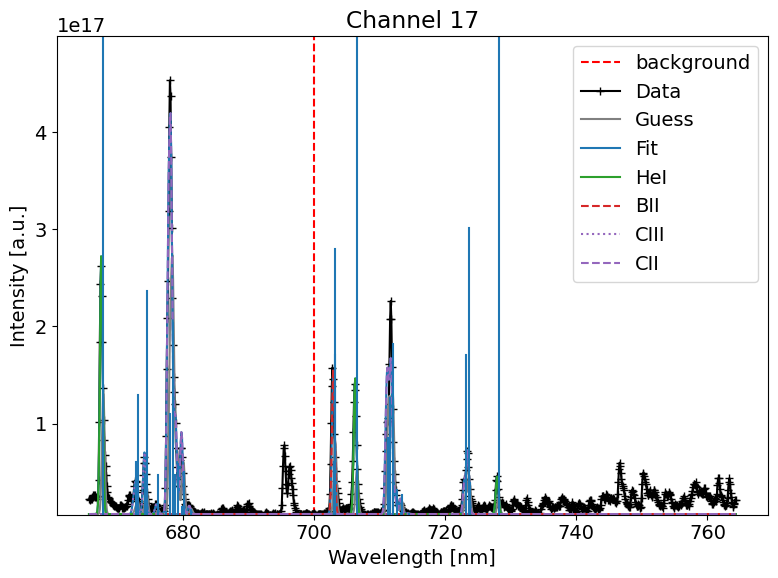

2024-03-01 14:38:27,804 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.818400269512153, 16.368450814987007, 15.958619252479608, 16.599755084770944, 16.389641289143217, 17.407015454083037, 17.13523690783886, 16.436723657470232]
2024-03-01 14:38:27,805 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.082075484865154, 14.082075484865154, 14.082075484865154, 14.082075484865154, 14.082075484865154, 14.082075484865154, 14.082075484865154, 14.082075484865154]
2024-03-01 14:38:27,807 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.296416915048916, 19.296416915048916, 19.296416915048916, 19.296416915048916, 19.296416915048916, 19.296416915048916, 19.296416915048916, 19.296416915048916]


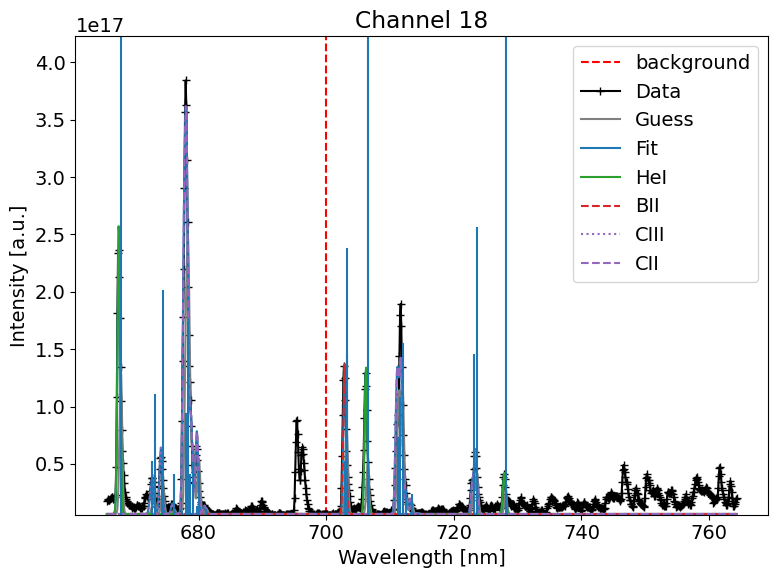

2024-03-01 14:38:28,391 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.858581348889754, 16.40039339594494, 15.97404622917633, 16.686767162466666, 16.416257424444776, 17.38006773417947, 17.099878627633576, 16.373137433632284]
2024-03-01 14:38:28,392 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.051506042127553, 14.051506042127553, 14.051506042127553, 14.051506042127553, 14.051506042127553, 14.051506042127553, 14.051506042127553, 14.051506042127553]
2024-03-01 14:38:28,393 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.14967014589154, 19.14967014589154, 19.14967014589154, 19.14967014589154, 19.14967014589154, 19.14967014589154, 19.14967014589154, 19.14967014589154]


Skipping broken channel 19
Skipping broken channel 20


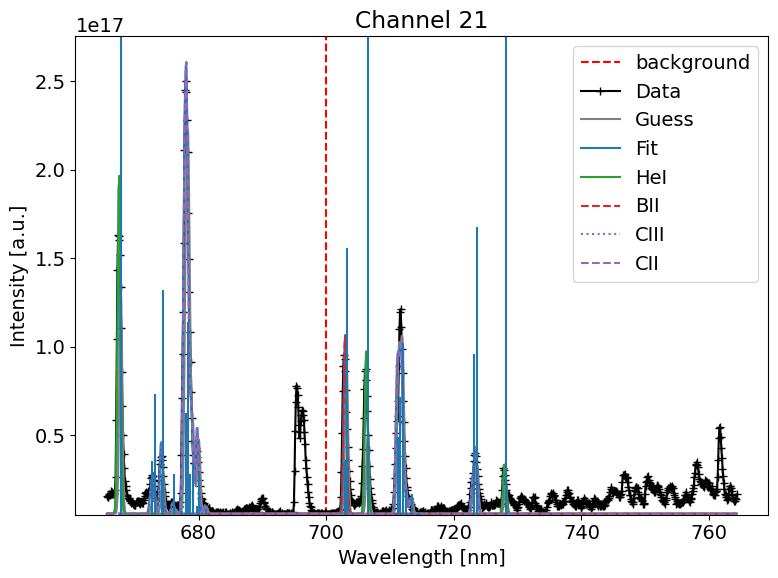

2024-03-01 14:38:29,043 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.861815797240986, 16.421517233720003, 15.970974944723096, 16.706040891604818, 16.394965713174006, 17.384976433256615, 17.08733175541177, 16.338504536011154]
2024-03-01 14:38:29,045 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.056008811643764, 14.056008811643764, 14.056008811643764, 14.056008811643764, 14.056008811643764, 14.056008811643764, 14.056008811643764, 14.056008811643764]
2024-03-01 14:38:29,046 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.121989776517122, 19.121989776517122, 19.121989776517122, 19.121989776517122, 19.121989776517122, 19.121989776517122, 19.121989776517122, 19.121989776517122]


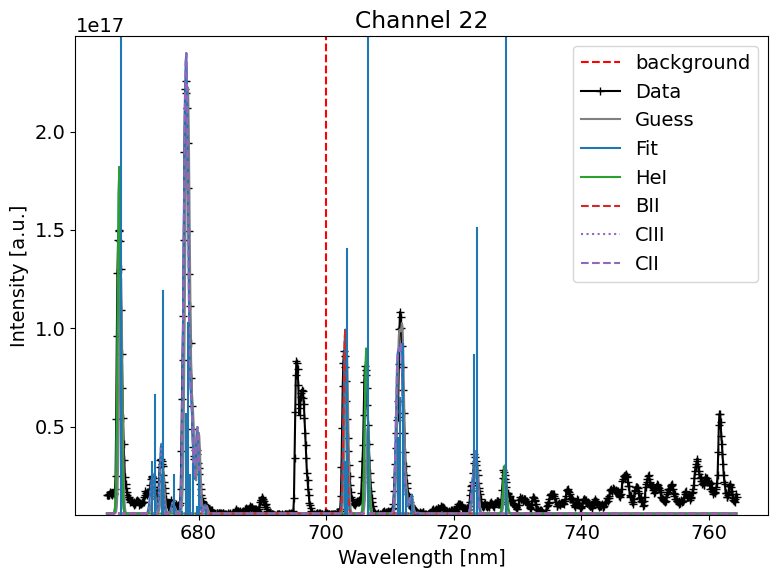

2024-03-01 14:38:29,771 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.869389839806264, 16.435905455429754, 15.97788277614023, 16.742913051768248, 16.395996416759715, 17.392067678948013, 17.09077027277563, 16.358674273679036]
2024-03-01 14:38:29,773 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.045748373636297, 14.045748373636297, 14.045748373636297, 14.045748373636297, 14.045748373636297, 14.045748373636297, 14.045748373636297, 14.045748373636297]
2024-03-01 14:38:29,774 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.08493017547252, 19.08493017547252, 19.08493017547252, 19.08493017547252, 19.08493017547252, 19.08493017547252, 19.08493017547252, 19.08493017547252]


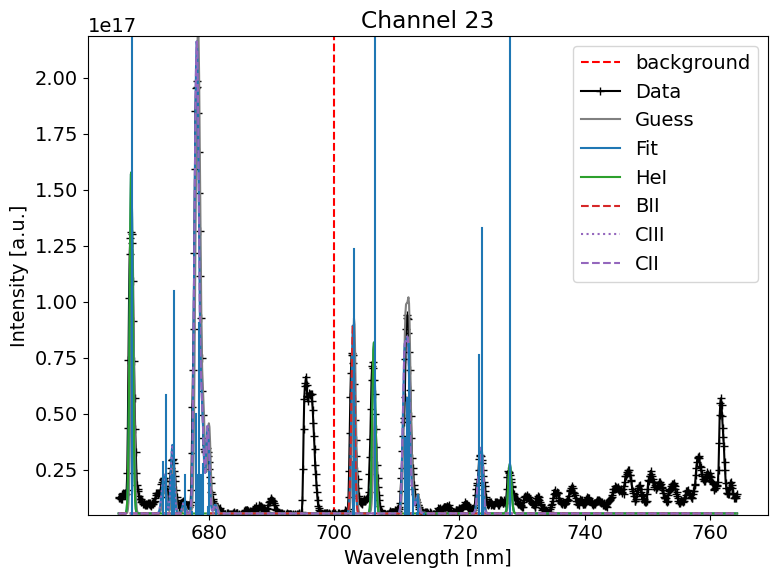

2024-03-01 14:38:30,446 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.87937497044421, 16.48135422749474, 16.006192286857637, 16.80201410236117, 16.403138094742157, 17.41904119692578, 17.119256681224492, 16.368414543780094]
2024-03-01 14:38:30,447 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.061087697410667, 14.061087697410667, 14.061087697410667, 14.061087697410667, 14.061087697410667, 14.061087697410667, 14.061087697410667, 14.061087697410667]
2024-03-01 14:38:30,449 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.078469125693168, 19.078469125693168, 19.078469125693168, 19.078469125693168, 19.078469125693168, 19.078469125693168, 19.078469125693168, 19.078469125693168]


Skipping broken channel 24


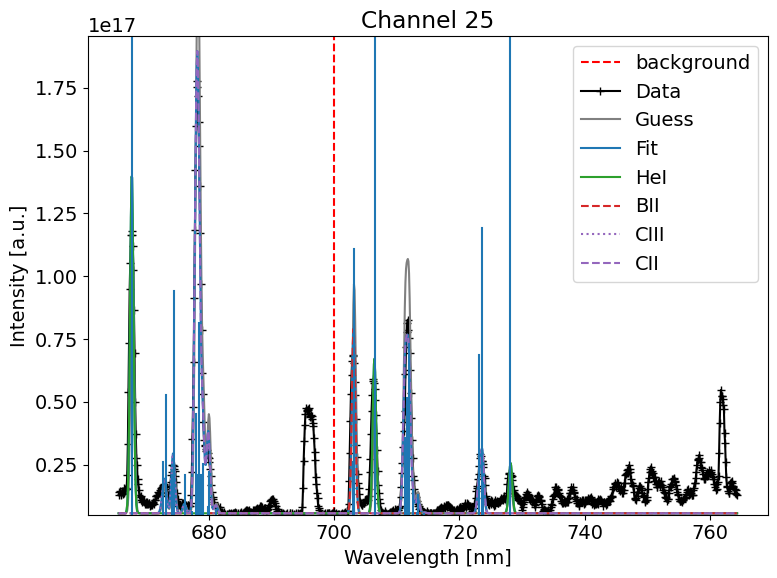

2024-03-01 14:38:31,064 - divertor_spectroscopy.analysis - DEBUG - guess [715.2, 0.09646545124624104, -8.646093507349151e-07, 16.738317359527983, 16.364201193240334, 15.855103310522333, 16.773654179995376, 16.269529375305464, 17.380743410319116, 17.058391115609183, 16.33310410328351]
2024-03-01 14:38:31,067 - divertor_spectroscopy.analysis - DEBUG - lower_bounds: [713, 0.095, -3e-06, 14.008525481435719, 14.008525481435719, 14.008525481435719, 14.008525481435719, 14.008525481435719, 14.008525481435719, 14.008525481435719, 14.008525481435719]
2024-03-01 14:38:31,069 - divertor_spectroscopy.analysis - DEBUG - upper_bounds: [717, 0.1, 1e-06, 19.007025025865456, 19.007025025865456, 19.007025025865456, 19.007025025865456, 19.007025025865456, 19.007025025865456, 19.007025025865456, 19.007025025865456]


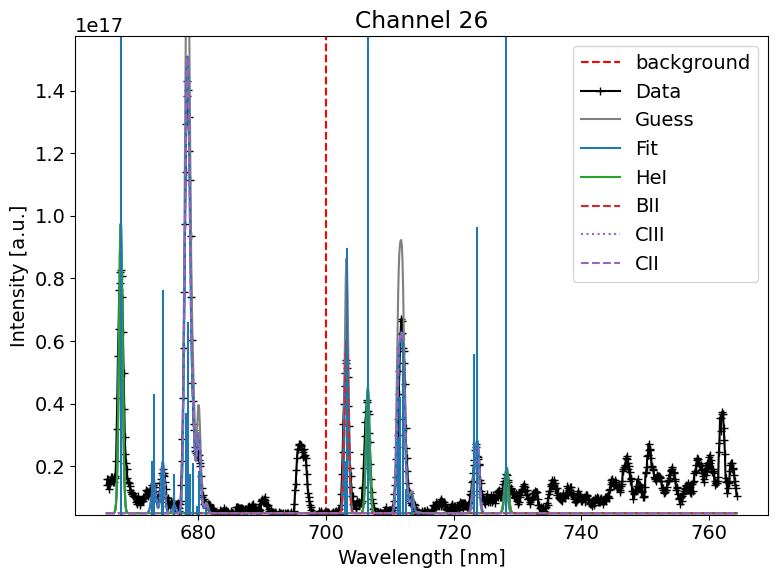

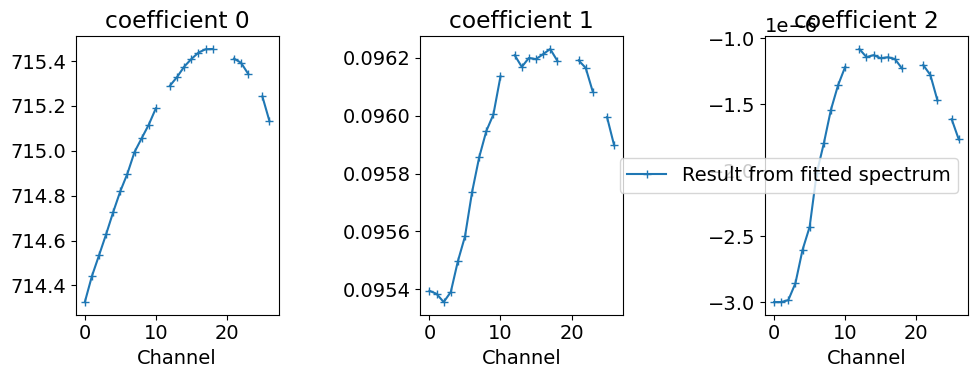

In [12]:
if ds_qss.central_wavelength == 405:
    strongest_line = 410.174 
if ds_qss.central_wavelength == 364:
    strongest_line = 369.421
if ds_qss.central_wavelength == 710:
    strongest_line = 
importlib.reload(wavelength_calibration)
wavelength_calibration.calibrate_spectrometer_using_datasource_qss_class(instrument_function_mode=instrument_function_mode,ds_qss=ds_qss,model=model,wavelength_coefficients_guess=ds_qss.wavelength_coefficients_guess,lower_bounds_wl=ds_qss.lower_bounds_wl,upper_bounds_wl=ds_qss.upper_bounds_wl,wcal=wcal,signal_type=signal_type,save_wavelength_calibration=save_wavelength_calibration,fit_coefficients=fit_coefficients,exclude_saturation_in_wl_calibration=exclude_saturation_in_wl_calibration,debug=debug)
    

### This wavelength calibration was done without Stark broadening - so let's reload the model fou you to play around with

In [13]:
if False:
    from divertor_spectroscopy.spectrum_models import ip320_cw_405
    importlib.reload(ip320_cw_405)
    zeeman = False
    stark_density = True
    debug = True
    model = ip320_cw_405.Ip320_cw_405(zeeman=zeeman,stark_density=stark_density,debug=debug)

### Cell for playing around with the spectrum

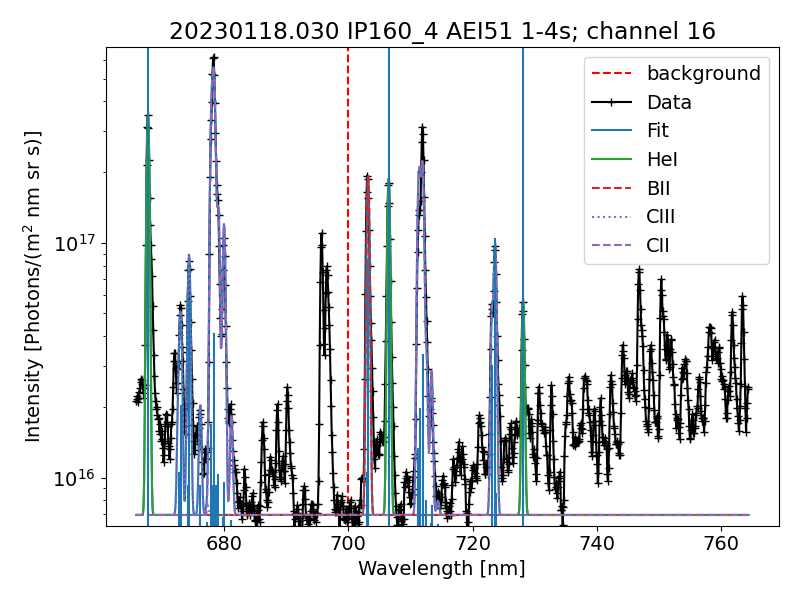

fit_description  fit_parameters  fit_parameters_linear      guess  \
0   Intensity_HeI_667.815       17.242063           1.746075e+17  17.232946   
1   Intensity_HeI_706.519       16.962081           9.163919e+16  16.933144   
2   Intensity_HeI_728.135       16.398560           2.503570e+16  16.343794   
3   Intensity_BII_703.200       16.992466           9.828024e+16  17.122246   
4  Intensity_CIII_674.063       16.905521           8.044900e+16  16.876683   
5   Intensity_CII_678.591       17.764619           5.815931e+17  17.880996   
6   Intensity_CII_711.798       17.403675           2.533231e+17  17.595963   
7   Intensity_CII_723.477       16.823349           6.658078e+16  16.854653   

   lower_bounds  upper_bounds  
0     14.179446     19.487951  
1     14.179446     19.487951  
2     14.179446     19.487951  
3     14.179446     19.487951  
4     14.179446     19.487951  
5     14.179446     19.487951  
6     14.179446     19.487951  
7     14.179446     19.487951

In [14]:
%matplotlib widget
signal_type = "signal_photons"
#signal_type = "signal_counts"
importlib.reload(analysis)
t = 1
t_to = 4#experiment_length
c_idx = 16

wavelength=ds_qss.data["wavelength_nm"][c_idx]
width = ds_qss.instrument_function[c_idx]*(np.abs(wavelength[0]-wavelength[-1])/len(wavelength))
numeric_instrument_function = ds_qss.numeric_instrument_function[c_idx]
inst = instrument.Instrument(wavelength=wavelength,width=width,instrument_function_mode=instrument_function_mode,numeric_instrument_function=numeric_instrument_function)
analyse = analysis.Analysis(model=model,instrument=inst)
t_idx = utils.val2idx(ds_qss.data["time_s"],t)
t_idx_to = utils.val2idx(ds_qss.data["time_s"],t_to)
debug = True
xlim = [399,405]
xlim = None
title = pid + " " + camid + " " + port + " " + str(t) + "-"+str(t_to)+ "s; channel " + str(c_idx) 
background_position = model.recommended_background_position
highlight_tags = model.all_tags
show_fit = False
experiment_data=np.nanmean(ds_qss.data[signal_type][t_idx:t_idx_to+1,c_idx],0)
analyse.fit_spectrum(experiment_data=experiment_data)
show_positions = True
scale = scale
analyse.display_spectrum(highlight_tags=highlight_tags,show_positions=show_positions,guess=False,xlim=xlim,ylabel=intensity_label,title=title,scale=scale)
analyse.format_fit_output()
analyse.fit_output

### I will give two default ways of analysing a discharge:
- fitting a profile
- fitting the maximum channel per strikeline

### Cell to fit a profile:
- todo: think about input of times

In [15]:
if True:
    importlib.reload(analysis)
    channels = np.arange(27)
    analysis_start_profil = 2
    analysis_end_profil = 5
    analysis_step_profil = 3
    profil = analysis.fit_profile(model=model,ds_qss=ds_qss,pid=pid,camid=camid,port=port,special_tags=[],xlim=xlim,intensity_label=intensity_label,scale=scale,channels=channels,signal_type=signal_type,analysis_start=analysis_start_profil,analysis_end=analysis_end_profil,analysis_step=analysis_step_profil)
    if camid == "IP320_2":
        lines = ["Intensity_H_delta","Intensity_NII_399.500"]
    if camid == "IP320_1":
        lines = ["Intensity_CIII_360.934"]
        lines = ['Intensity_NeII 3s2P-3p2D_371.315',
    'Intensity_NeII 3s4P-3p4P_371.046',
    'Intensity_NeII 3s2D-3p2F_357.111',]
    plt.figure(figsize=(8, 6))
    plt.title(
        "12.3° {} {} {} {} - {} s".format(camid, pid, port, analysis_start_profil,analysis_end_profil))
    for line in lines:
        plt.plot(channels,10**profil["fit_parameters"][line][0], "+-",label=line)
    plt.xlabel("Channel")
    plt.ylabel(intensity_label)
    plt.gca().set_ylim(bottom=0)
    # Add arrow pointing to the left
    plt.arrow(0.6, 0.2, -0.1, 0, head_width=0.05, head_length=0.05, fc='red', ec='red', width=0.02,
        transform=plt.gca().transAxes)
    plt.text(0.2, 0.19, 'Horizontal target', fontsize=12, color='red',
        transform=plt.gca().transAxes)
    # Add arrow pointing right
    plt.arrow(0.65, 0.2, 0.1, 0, head_width=0.05, head_length=0.05, fc='blue', ec='blue', width=0.02,
            transform=plt.gca().transAxes)
    plt.text(0.8, 0.19, 'Vertical target', fontsize=12, color='blue',
        transform=plt.gca().transAxes)
    plt.grid()
    plt.legend()
    plt.show()

TypeError: 'NoneType' object is not subscriptable

### Fitting entire discharge at max intensity per strikeline

In [ ]:
output = {}
debug = False
for strikeline in strikelines:
    output[strikeline] = analysis.fit_discharge_brightest_channel(debug=debug,highlight_tags=model.all_tags,model=model,ds_qss=ds_qss,pid=pid,camid=camid,port=port,special_tags=[],xlim=xlim,intensity_label=intensity_label,scale=scale,exclude_channels=exclude_channels,strikeline=strikeline,strongest_line=strongest_line,signal_type=signal_type,analysis_start=analysis_start,analysis_end=analysis_end,analysis_step=analysis_step) 

2024-01-17 13:16:41,790 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite


2024-01-17 13:17:29,404 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite
2024-01-17 13:17:29,413 - divertor_spectroscopy.analysis - DEBUG - Intensity guess not finite


c:\Users\frhe\AppData\Local\anaconda3\envs\qss\lib\site-packages\ipykernel_launcher.py:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "+-" (-> linestyle='-'). The keyword argument will take precedence.
  from ipykernel import kernelapp as app


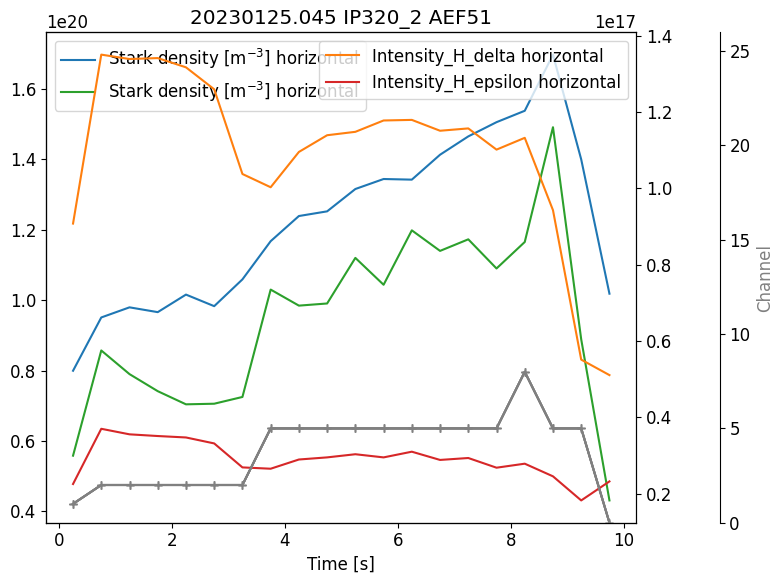

In [ ]:
#%matplotlib widget
fontsize = 12
plt.rcParams.update({'font.size': fontsize})
parameters = ['Stark_density_H_delta', "Intensity_H_delta",'Stark_density_H_epsilon', "Intensity_H_epsilon"] # parameters you want to display
fig, ax1 = plt.subplots(figsize=(8,6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
for parameter in parameters:
    for strikeline in strikelines:
        if "density" in parameter:
            ax1.plot(output[strikeline]["time"],10**output[strikeline]["fit_parameters"][parameter],ls=ls[strikeline],c=colors[parameters.index(parameter)],label="Stark density [m$^{-3}$] "+strikeline)
        if "Intensity" in parameter:
            ax2.plot(output[strikeline]["time"],10**output[strikeline]["fit_parameters"][parameter],ls=ls[strikeline],c=colors[parameters.index(parameter)],label=parameter+" "+strikeline)
    ax3.plot(output[strikeline]["time"],output[strikeline]["channels"],"+-",ls=ls[strikeline],c="grey",label=strikeline[0]+" Channels")
    
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax1.set_xlabel("Time [s]")
title = pid+" "+camid+" "+port
#ax1.set_ylim(0,6)
#ax2.set_ylim(0,2)
ax3.set_ylim(0,26)
ax3.set_ylabel("Channel",color="grey")
plt.title(title)
plt.tight_layout()
plt.show()